# Thermovision segmentation (altitude & rotation)

## HIT-UAV Dataset

*HIT-UAV provides essential flight data for each image, including flight altitude, camera perspective, date, and daylight intensity. <br>
For each image, the authors have manually annotated object instances with bounding boxes of two types (oriented and standard) <br>to tackle the challenge of significant overlap of object instances in aerial images.*

In [1]:
from pathlib import Path

import cv2
import numpy as np

from src.data import save_alt_rot_images_annotations
from src.utils.process_image import add_altitude_rotation_channel
from src.utils.read_file import XMLReader, read_file_to_list
from src.visualizations import plot_rotated_images

ANNOTATIONS_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/Annotations"
DATA_SPLIT_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/ImageSets/Main"
IMAGES_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/JPEGImages"

#### Load annotations

In [2]:
xml_reader = XMLReader(ANNOTATIONS_PATH)
annotations = xml_reader.getAnnotation()

In [3]:
# examplary annotation
annotations['0_100_30_0_03280']

{'picname': 'C:\\Users\\suoji\\Desktop\\data_pro\\images_data_new\\day\\100m\\-30\\20210116\\0_100_30_0_03280.jpg',
 'size': {'width': 640, 'height': 512, 'depth': 1},
 'nobbox': [],
 'robbox': [{'category': 'Car',
   'cx': 215.984,
   'cy': 120.9863,
   'w': 32.276,
   'h': 15.9103,
   'angle': 2.589049,
   'difficult': False},
  {'category': 'Car',
   'cx': 373.7907,
   'cy': 97.5358,
   'w': 27.4285,
   'h': 19.3339,
   'angle': 0.559865,
   'difficult': False},
  {'category': 'Car',
   'cx': 134.6054,
   'cy': 141.7191,
   'w': 25.4252,
   'h': 18.4471,
   'angle': 2.279669,
   'difficult': False},
  {'category': 'Car',
   'cx': 32.4545,
   'cy': 200.0871,
   'w': 27.7836,
   'h': 13.3051,
   'angle': 0.796474,
   'difficult': False},
  {'category': 'Car',
   'cx': 43.7676,
   'cy': 192.7359,
   'w': 31.907,
   'h': 17.0008,
   'angle': 0.650521,
   'difficult': False},
  {'category': 'Car',
   'cx': 58.5022,
   'cy': 187.6378,
   'w': 14.5995,
   'h': 32.0022,
   'angle': 2.335935

In [4]:
image_names = dict()
for key in ["train", "val", "test"]:
    image_names[key] = read_file_to_list(f"{DATA_SPLIT_PATH}/{key}.txt")

#### Visualize n random images from the training set

In [5]:
n = 15
random_images = np.random.choice(np.arange(len(image_names['train'])), n, replace=False)
random_images = [image_names['train'][i] for i in random_images]
# random_images

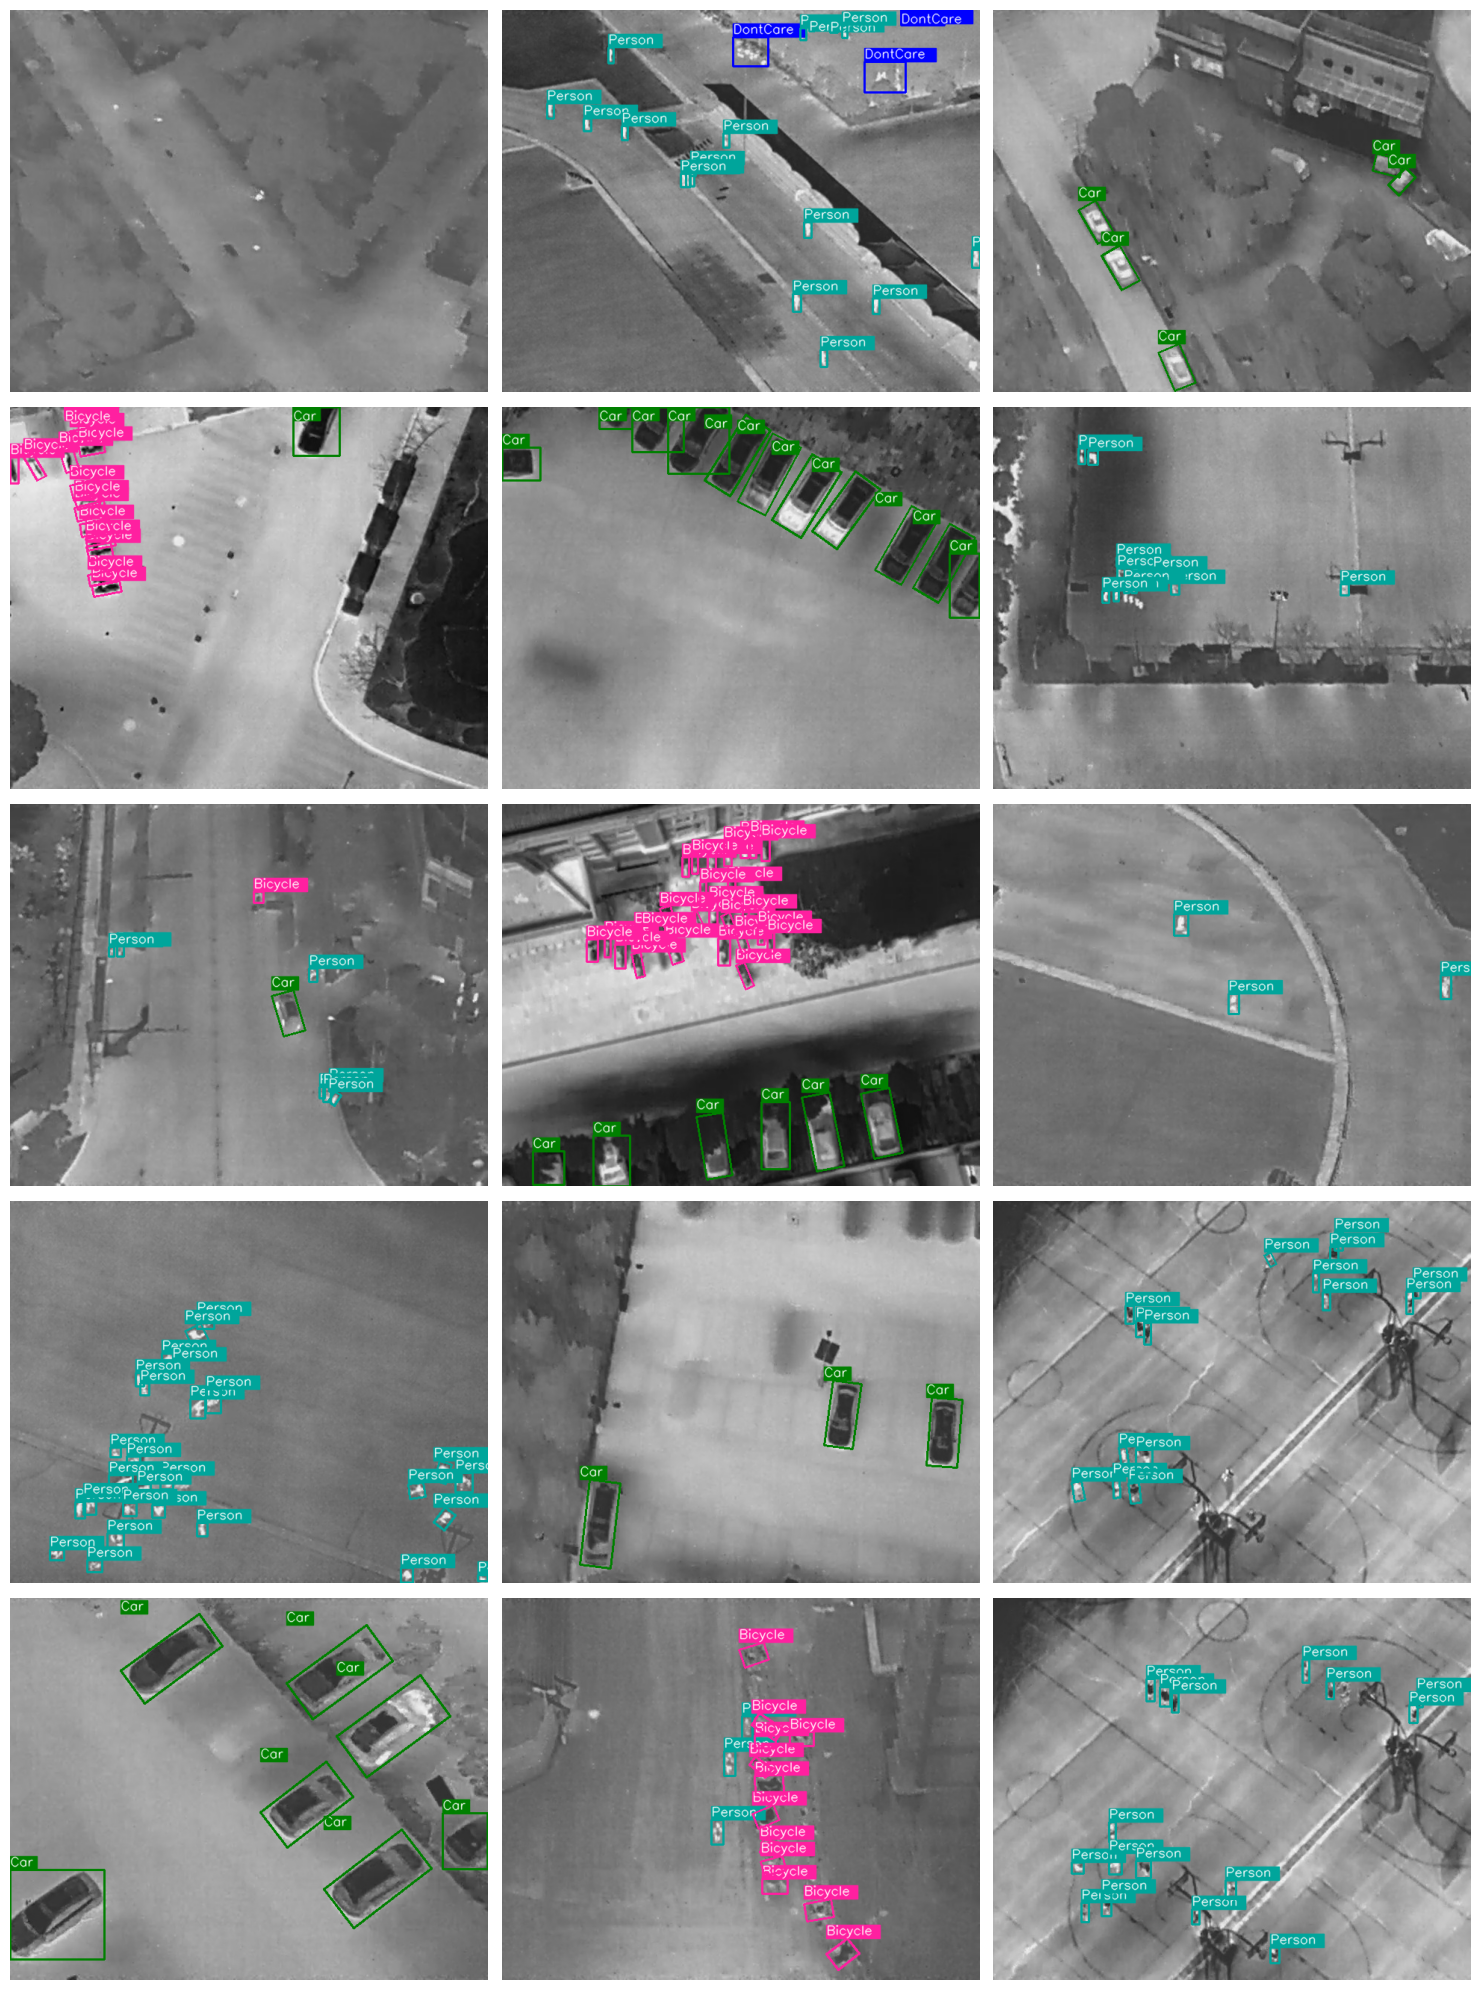

In [6]:
rows = 5
cols = 3
plot_rotated_images(IMAGES_PATH, random_images, annotations, rows, cols)

### Add the altitude information as an additional input channel

Following the idea from the paper: [Elevating point-based object detection in UAVs: A deep learning method with altitude fusion](https://ww2.mini.pw.edu.pl/pprai2024/papers/105.pdf) <br>(presented at the PP RAI 2024 conference), we added the information about the altitude as a separate channel (i.e. using *Method A*):

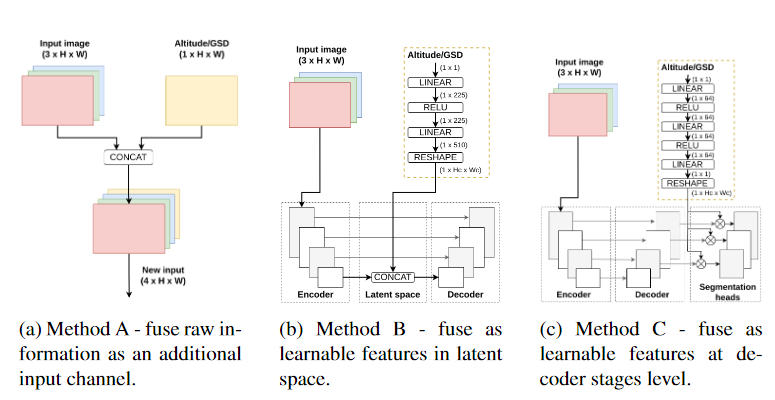

In [7]:
image_name = image_names['train'][0]

image = cv2.imread(f"{IMAGES_PATH}/{image_name}.jpg")

In [ ]:
print(image_name)
image_alt_rot = add_altitude_rotation_channel(image, image_name)
image_alt_rot.shape

In [12]:
img_dir = Path("data/data_angle/images")
class_dict = {"Person": 0, "Car": 1, "Bicycle": 2, "OtherVehicle": 3, "DontCare": 4}
ann_dir = Path("data/data_angle/labels")
save_alt_rot_images_annotations(img_dir, ann_dir, image_names, IMAGES_PATH, annotations, class_dict, "rotation")

## Train oriented bounding box yolo (OBB)

In [1]:
from ultralytics import YOLO

model = YOLO("yolov8n-obb.yaml")
results = model.train(data="data/data_altitude/dataset.yaml", imgsz=512, epochs=50, batch=16, name="yolov8n-obb_50e_altitude")